In [1]:
from cell_env import CellEnv
import matplotlib.pyplot as plt
import numpy as np

from plot_utils import plot_observations, evaluate_model, plot_actions
import os
WANDB_DIR = os.getenv("WANDB_DIR", ".")

In [2]:
# Example usage:
env_args = {
    "max_timesteps": 10000,
    "alpha_mem": 0.7,
    "dt": 0.01,
    "frame_stack": 40,
}

model_str = f"{WANDB_DIR}/sweep-models/silver-sweep-360/best_model.zip"

eval_env = CellEnv(**env_args)

all_obs, all_actions, all_fractions = evaluate_model(env_args, 1, model_str, multiprocess=True)


In [3]:
on_obs, on_actions, on_fractions = evaluate_model(env_args, 2, 'on', multiprocess=True)
off_obs, off_actions, off_fractions = evaluate_model(env_args, 2, 'off', multiprocess=True)

KeyboardInterrupt: 

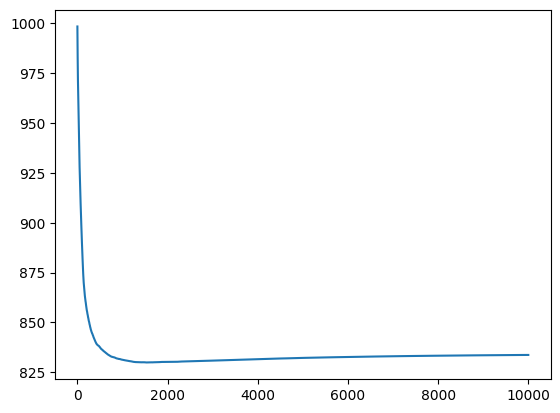

In [4]:
plt.plot(all_obs.mean(axis=0), label='all')
# plt.ylim(700,1000)
# plt.xlim(0,100)

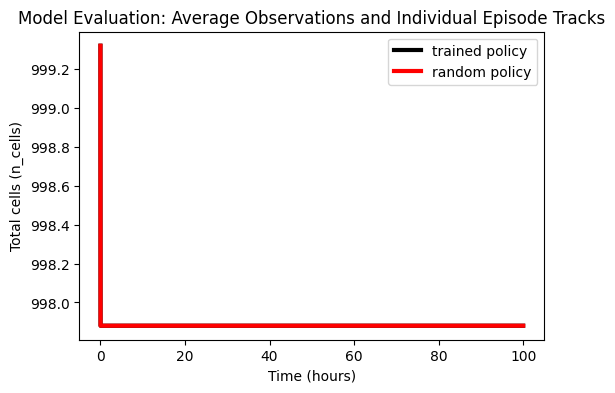

In [ ]:
plot_observations(env_args, all_obs, on_obs, alpha_val=0.25)

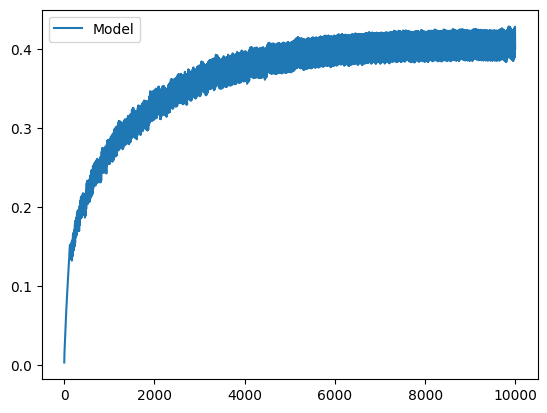

In [5]:
plt.plot(all_fractions.mean(axis=0), label="Model")
# plt.plot(unif_fractions.mean(axis=0), label="Uniform")
plt.legend()
# plt.xscale('log')

(2000.0, 3000.0)

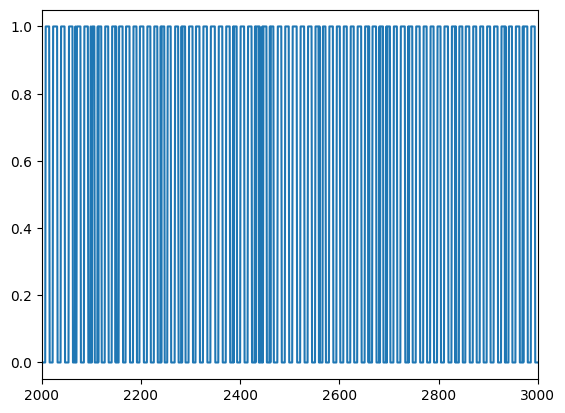

In [10]:
plt.plot(all_actions.mean(axis=0))
plt.xlim(2000,3000)

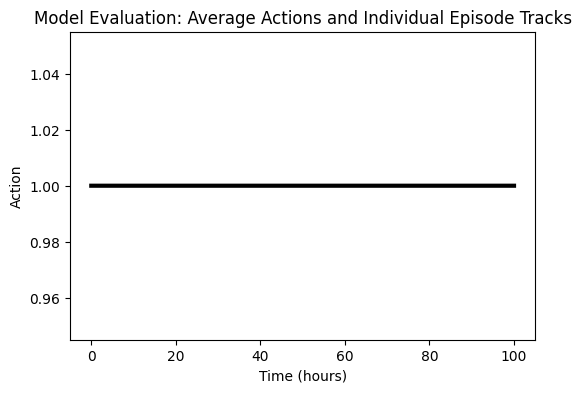

In [ ]:
plot_actions(env_args, all_actions)

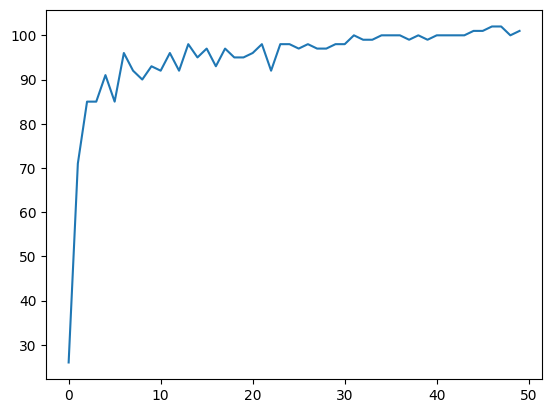

In [7]:
# bin the actions and plot average frequency in each bin over time:
avg_actions = np.array(all_actions).mean(axis=0)
freqs=[]
time_chunks = 50
for i in range(time_chunks):
    interval = len(avg_actions)//time_chunks
    action_subset = avg_actions[interval*i:interval*(i+1)]
    # number of zeros:
    switches = len(action_subset[action_subset == 0])
    freqs.append(switches)
plt.plot(freqs)
